In [1]:
!pip install konlpy
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 33.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Okt
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from keras.utils import to_categorical


# 데이터 불러오기
try:
    urllib.request.urlretrieve("https://raw.githubusercontent.com/tonykorea99/Spam-alart/main/EditData.csv", filename='EditData.csv')
    data = pd.read_csv('EditData.csv', encoding='utf-8')
    data = data.sample(frac=1, random_state=42)
    print('총 샘플 수:', len(data))
except Exception as e:
    print('에러 발생:', e)

# 필요한 열 선택 및 중복 제거
data = data[['v1', 'v2']]
data['v1'] = data['v1'].replace(['ham', 'spam'], [0, 1])
data.drop_duplicates(subset=['v2'], inplace=True)
print('중복 제거 후의 전체 샘플 수:', len(data))

# 형태소 분리
okt = Okt()

# 형태소 분리 및 토크나이징
data['tokens'] = data['v2'].apply(lambda x: okt.morphs(x))

# Doc2Vec 모델 학습을 위한 태그 설정
tagged_data = [TaggedDocument(words=_d, tags=[str(i)]) for i, _d in enumerate(data['tokens'])]

# Doc2Vec 모델 학습
model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# 문서를 벡터로 변환
X = [model.infer_vector(doc.words) for doc in tagged_data]

# 레이블 및 데이터 분리
y = data['v1'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<ipython-input-2-abde83b7e87b>:20: DtypeWarning: Columns (2,3,4,5,6,10,11,15,16,20,21,25,26,30,31,35,36,40,41,45,46,50,51,55,56,60,61,65,66,70,71,75,76,80,81,85,86,90,91,95,96,100,101,105,106,110,111,115,116,120,121,125,126,130,131,135,136,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('EditData.csv', encoding='utf-8')


총 샘플 수: 24633
중복 제거 후의 전체 샘플 수: 24353


In [10]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences

# LSTM 모델에 레이어 추가
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=len(model.wv.index_to_key), output_dim=200, input_length=model.vector_size))
model_lstm.add(Bidirectional(LSTM(128, return_sequences=True)))  # 추가된 LSTM 레이어
model_lstm.add(Bidirectional(LSTM(128)))
model_lstm.add(Flatten())  # 추가: 3D 텐서를 2D 텐서로 변환
model_lstm.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 문서 벡터에 패딩 추가
X_train_pad = pad_sequences(X_train)
X_test_pad = pad_sequences(X_test, maxlen=X_train_pad.shape[1])  # X_test의 패딩 길이를 X_train에 맞춤

# 모델 훈련
model_lstm.fit(X_train_pad, y_train, epochs=20, batch_size=64, validation_split=0.1)

# 모델 평가
loss, accuracy = model_lstm.evaluate(X_test_pad, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')


Epoch 1/20
274/274 [==============================] - 22s 37ms/step - loss: 0.6290 - accuracy: 0.6078 - val_loss: 0.6221 - val_accuracy: 0.6229
Epoch 2/20
274/274 [==============================] - 8s 30ms/step - loss: 0.6248 - accuracy: 0.6167 - val_loss: 0.6237 - val_accuracy: 0.6219
Epoch 3/20
274/274 [==============================] - 7s 24ms/step - loss: 0.6157 - accuracy: 0.6221 - val_loss: 0.6209 - val_accuracy: 0.6213
Epoch 4/20
274/274 [==============================] - 6s 23ms/step - loss: 0.6145 - accuracy: 0.6242 - val_loss: 0.6213 - val_accuracy: 0.6213
Epoch 5/20
274/274 [==============================] - 7s 24ms/step - loss: 0.6147 - accuracy: 0.6193 - val_loss: 0.6211 - val_accuracy: 0.6213
Epoch 6/20
274/274 [==============================] - 6s 23ms/step - loss: 0.6170 - accuracy: 0.6171 - val_loss: 0.6177 - val_accuracy: 0.6229
Epoch 7/20
274/274 [==============================] - 7s 24ms/step - loss: 0.6149 - accuracy: 0.6220 - val_loss: 0.6201 - val_accuracy: 0.622

In [11]:
# 스미싱 분류 모델 불러오기
loaded_smishing_model = model_lstm
okt = Okt()

model_lstm.summary()

def classify_smishing(input_text):
    # 형태소 분석기 사용 (Okt)
    tokens = okt.morphs(input_text)  # 토큰화

    # 정수 인덱스로 변환
    encoded = [[model.wv.key_to_index[word] for word in tokens if word in model.wv.key_to_index]]
    pad_tokens = pad_sequences(encoded, maxlen=100, padding='post')

    # 모델 예측
    smishing_score = loaded_smishing_model.predict(pad_tokens.astype('float32'))[0][0]

    # 스미싱 여부 판단 결과 출력
    if smishing_score > 0.5:
        print("{:.2f}% 확률로 스미싱입니다.".format(smishing_score * 100))
    else:
        print("{:.2f}% 확률로 일반 메시지입니다.".format((1 - smishing_score) * 100))

# 사용자로부터 텍스트 입력 받기
user_input_text = input("텍스트를 입력하세요: ")

# 스미싱 여부 판단 수행
classify_smishing(user_input_text)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 200)          4966000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 100, 256)          336896    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 5697393 (21.73 MB)
Trainable params: 569

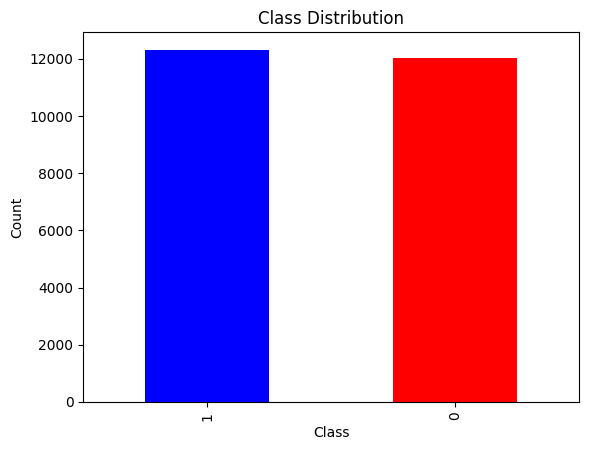

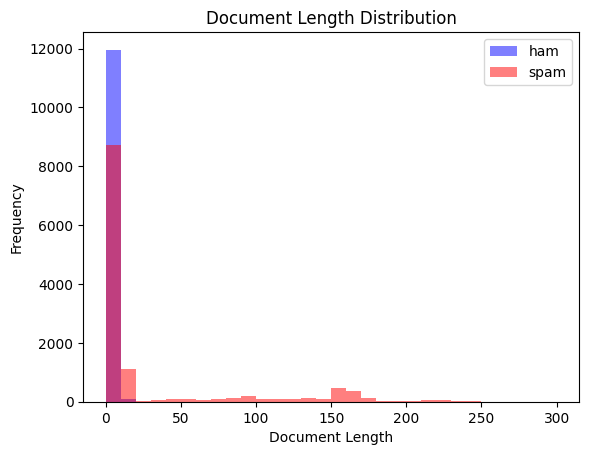

Top 5 words in spam messages:
ifg ifg: 18349
Web발신 ifg: 4678
가능합니다 ifg: 2517
ifg https: 2440
국제발신 ifg: 2381

Top 5 words in ham messages:
키키: 1961
하하: 605
안: 528
진짜: 485
ㅠㅠ: 449


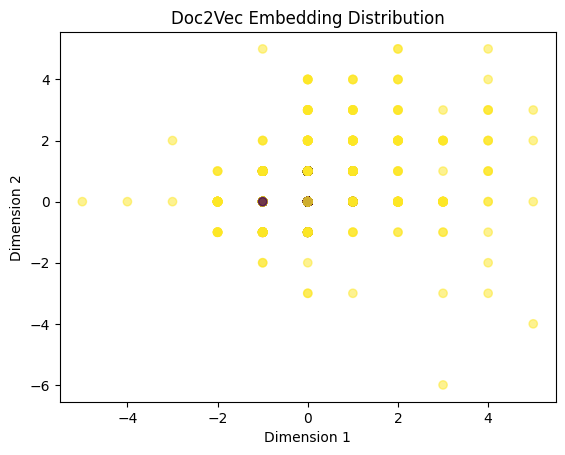

In [5]:

from wordcloud import WordCloud
# 클래스 분포 확인
data['v1'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# 문서 길이 분포 확인
data['doc_length'] = data['v2'].apply(lambda x: len(x.split()))
plt.hist(data[data['v1'] == 0]['doc_length'], bins=30, alpha=0.5, label='ham', color='blue', range=(0, 300))  # 수정된 부분
plt.hist(data[data['v1'] == 1]['doc_length'], bins=30, alpha=0.5, label='spam', color='red', range=(0, 300))  # 수정된 부분
plt.title('Document Length Distribution')
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 단어 빈도수 계산
word_frequencies_spam = WordCloud().process_text(' '.join(data[data['v1'] == 1]['v2']))
word_frequencies_ham = WordCloud().process_text(' '.join(data[data['v1'] == 0]['v2']))

# 가장 빈번하게 나타나는 단어 출력 (스미싱문자)
print("Top 5 words in spam messages:")
frequent_words_spam = sorted(word_frequencies_spam.items(), key=lambda x: x[1], reverse=True)[:5]
for word, freq in frequent_words_spam:
    print(f"{word}: {freq}")

# 가장 빈번하게 나타나는 단어 출력 (일반문자)
print("\nTop 5 words in ham messages:")
frequent_words_ham = sorted(word_frequencies_ham.items(), key=lambda x: x[1], reverse=True)[:5]
for word, freq in frequent_words_ham:
    print(f"{word}: {freq}")


# 학습 데이터에 대한 임베딩 분포 시각화
plt.scatter(X_train_pad[:, 0], X_train_pad[:, 1], c=y_train, cmap='viridis', alpha=0.5)
plt.title('Doc2Vec Embedding Distribution')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()